In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[*********************100%***********************]  1 of 1 completed


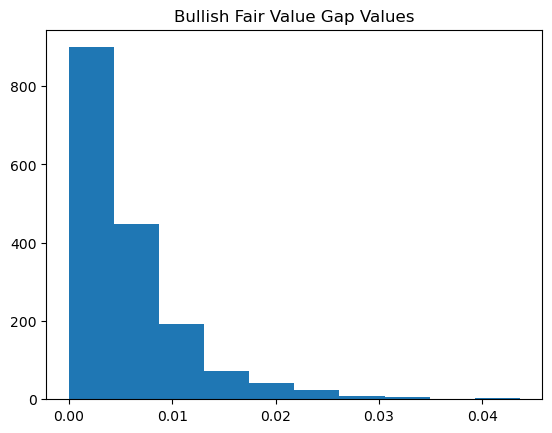

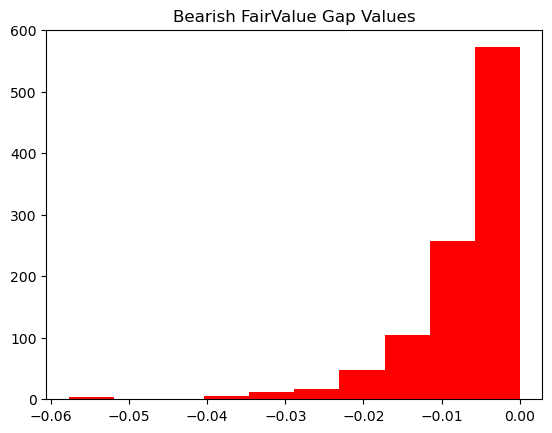

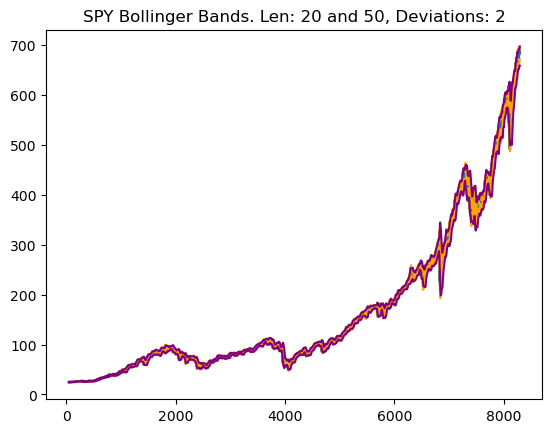

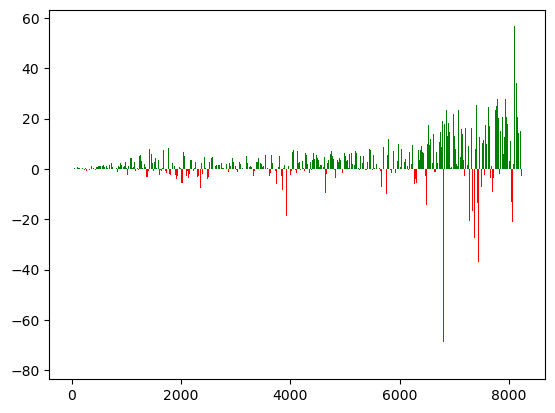

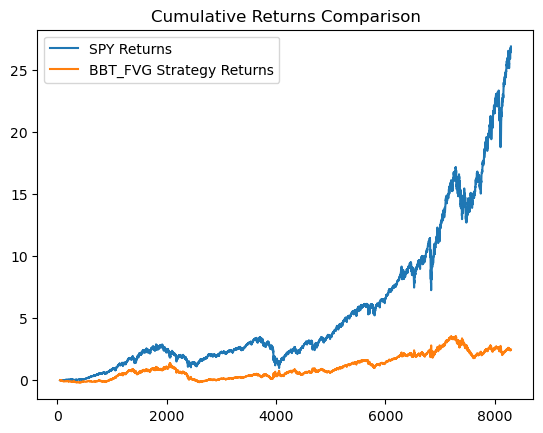

Price,Date,Close,High,Low,Open,Volume,High_2prev,Bull_FVG,Bull_FVG_Val,Low_2prev,...,Upper_Band_2,Lower_Band_2,BB_hist,BBT_strategy,BBT_signal,full_strategy,signal,strategy,Asset_returns,strategy_returns
49,1993-04-12,24.892900,24.910223,24.754318,24.788964,348500,24.581087,1,0.006959,24.477150,...,25.371131,24.013922,0.305088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,1993-04-13,24.944876,25.031490,24.858262,24.875584,146100,24.685028,1,0.006945,24.442509,...,25.376134,24.037058,0.271434,0.0,NaN,1.0,1.0,0.0,0.002088,0.000000
51,1993-04-14,24.910231,24.979522,24.892908,24.962199,119600,24.910223,0,-0.000000,24.754318,...,25.383057,24.049991,0.242599,0.0,NaN,1.0,1.0,1.0,0.000696,-0.001389
52,1993-04-15,24.910231,24.962199,24.806294,24.892908,148600,25.031490,0,-0.000000,24.858262,...,25.390147,24.060689,0.231349,0.0,NaN,1.0,1.0,1.0,0.000696,-0.001389
53,1993-04-16,24.910231,24.962199,24.875585,24.927553,47900,24.979522,0,-0.000000,24.892908,...,25.395920,24.062359,0.214927,0.0,NaN,1.0,1.0,1.0,0.000696,-0.001389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8289,2026-01-05,687.719971,689.429993,686.380005,686.539978,71927200,687.359985,0,-0.000000,681.710022,...,695.397499,659.678617,10.922059,1.0,1.0,2.0,1.0,1.0,26.627153,2.440207
8290,2026-01-06,691.809998,692.320007,687.780029,687.929993,69273800,686.869995,1,0.001315,679.820007,...,696.141316,659.815964,10.854915,1.0,1.0,2.0,1.0,1.0,26.791458,2.460667
8291,2026-01-07,689.580017,693.960022,689.320007,692.190002,75588300,689.429993,0,-0.000000,686.380005,...,696.702314,659.827979,11.078313,1.0,1.0,2.0,1.0,1.0,26.701875,2.449511
8292,2026-01-08,689.510010,690.619995,687.489990,688.820007,64019200,692.320007,0,-0.000000,687.780029,...,697.050553,659.731295,11.675000,1.0,1.0,2.0,1.0,1.0,26.699063,2.449161


In [15]:
ticker = "SPY"
interval = '1d'
period = 'max'

devs= 2
BB_LENGTH_1 = 20 
BB_LENGTH_2 = 50
LOOKBACK = -10000



def get_data(ticker, lookback=LOOKBACK, interval=interval, period=period):
    df = yf.download(ticker, period = period, auto_adjust=True, interval=interval)
    #reset index to get datetime as a column
    df = df.reset_index()

    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

    #only return data after lookback
    return df.iloc[lookback:,:]

def bull_fvg(df):

    df['High_2prev'] = df['High'].shift(2)
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    df['Bull_FVG_Val'] = (df['Low'] - df['High_2prev']) * df['Bull_FVG'] / df['Close']

    fvg_subset = df[df['Bull_FVG_Val'] > 0]

    
    plt.hist(fvg_subset['Bull_FVG_Val'], bins=10)
    plt.title("Bullish Fair Value Gap Values")

    return df

def bear_fvg(df):

    df['Low_2prev'] = df['Low'].shift(2)
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    df['Bear_FVG_Val'] = (df['High'] - df['Low_2prev']) * df['Bear_FVG'] / df['Close']

    fvg_subset = df[df['Bear_FVG_Val'] < 0]

    plt.figure()
    plt.hist(fvg_subset['Bear_FVG_Val'], bins=10, color='red')
    plt.title("Bearish FairValue Gap Values")

    return df

def FVG_strategy(df):
    df['FVG_strategy'] = 0
    buy_signal = (df['Bull_FVG_Val'] > 0)
    sell_signal = (df['Bear_FVG_Val'] < 0)

    conditions = [buy_signal, sell_signal]
    choices = [1, -1]

    df['FVG_strategy'] = np.select(conditions, choices, default=np.nan)

    df['FVG_strategy'] = df['FVG_strategy'].ffill()
    df['FVG_strategy'] = df['FVG_strategy'].fillna(0)
    df['FVG_strategy'] = df['FVG_strategy'].shift(1)  #shift by 1 to avoid lookahead bias
    return df

def FVG_strategy_medium(df):
    all_bull_fvgs = df[df['Bull_FVG_Val'] > 0]['Bull_FVG_Val']
    lower_b = all_bull_fvgs.quantile(0.25)
    upper_b = all_bull_fvgs.quantile(0.75)

    is_medium_bull = (df['Bull_FVG_Val'] >= lower_b) & (df['Bull_FVG_Val'] <= upper_b)
    buy_signal = is_medium_bull

    all_bear_fvgs = df[df['Bear_FVG_Val'] < 0]['Bear_FVG_Val']
    lower_s = all_bear_fvgs.quantile(0.25)
    upper_s = all_bear_fvgs.quantile(0.75)

    is_medium_bear = (df['Bear_FVG_Val'] >= lower_s) & (df['Bear_FVG_Val'] <= upper_s)

    # Define Signal
    sell_signal = is_medium_bear

    conditions = [buy_signal, sell_signal]
    choices = [1, -1]

    df['FVG_strategy'] = np.select(conditions, choices, default=np.nan)

    df['FVG_strategy'] = df['FVG_strategy'].ffill()
    df['FVG_strategy'] = df['FVG_strategy'].fillna(0)
    df['FVG_strategy'] = df['FVG_strategy'].shift(1)  #shift by 1 to avoid lookahead bias

    return df

def add_bollinger_bands(df, BB_LENGTH_1, BB_LENGTH_2, devs): 
    ##11
    df['BB_SMA_1'] = df['Close'].rolling(window=BB_LENGTH_1).mean() 
    df['STD_1'] = df['Close'].rolling(window=BB_LENGTH_1).std()
    df['Upper_Band_1'] = df['BB_SMA_1'] + (df['STD_1'] * devs)
    df['Lower_Band_1'] = df['BB_SMA_1'] - (df['STD_1'] * devs)

    ##22
    df['BB_SMA_2'] = df['Close'].rolling(window=BB_LENGTH_2).mean() 
    df['STD_2'] = df['Close'].rolling(window=BB_LENGTH_2).std()
    df['Upper_Band_2'] = df['BB_SMA_2'] + (df['STD_2'] * devs)
    df['Lower_Band_2'] = df['BB_SMA_2'] - (df['STD_2'] * devs)

    df = df.dropna().copy()

    df['BB_hist'] = (abs(df['Lower_Band_1'] - df['Lower_Band_2']) - abs(df['Upper_Band_2'] - df['Upper_Band_1']))

    plt.figure()
    plt.plot(df['Close'])
    plt.plot(df['Upper_Band_1'], color='orange')
    plt.plot(df['Lower_Band_1'], color='orange')
    plt.plot(df['Upper_Band_2'], color = 'purple')
    plt.plot(df['Lower_Band_2'], color = 'purple')
    plt.title(f'{ticker} Bollinger Bands. Len: {BB_LENGTH_1} and {BB_LENGTH_2}, Deviations: {devs}')

    plt.figure()
    plt.bar(range(len(df)), df['BB_hist'], color=np.where(df['BB_hist']<0, 'red', 'green'))

    return df

def BBT_strategy(df):
    threshold = df['BB_hist'].std() * 0.5

    df['BBT_strategy'] = 0
    
    # 1. Define Conditions with a "Buffer Zone"
    conditions = [
        (df['BB_hist'] > threshold),  # Strong Uptrend (Green)
        (df['BB_hist'] < -threshold)  # Strong Downtrend (Red)
    ]
    
    choices = [1, -1] # Long, Short
    
    # 2. Generate Signals
    # If between -threshold and +threshold, default to NaN (Hold)
    df['BBT_signal'] = np.select(conditions, choices, default=np.nan)
    
    # 3. Forward Fill (The Memory)
    df['BBT_strategy'] = df['BBT_signal'].ffill()
    df['BBT_strategy'] = df['BBT_strategy'].fillna(0)
    
    # 4. Shift logic
    df['BBT_strategy'] = df['BBT_strategy'].shift(1)
    
    return df

def add_full_strategy(df):
    df['full_strategy'] = df['BBT_strategy'] + df['FVG_strategy']

    conditions = [
        (df['full_strategy'] > 0), 
        (df['full_strategy'] < 0)   ]
    choices = [1, -1]
    
    df['signal'] = np.select(conditions, choices, default=np.nan)

    df['strategy'] = df['signal'].ffill()
    df['strategy'] = df['strategy'].fillna(0)
    df['strategy'] = df['strategy'].shift(1)

    return df

def test_strategy(df):
    df['Asset_returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['strategy_returns'] = (1 + df['Close'].pct_change() * df['strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_returns'], label=f'{ticker} Returns')
    plt.plot(df['strategy_returns'], label='BBT_FVG Strategy Returns')
    plt.legend()
    plt.title('Cumulative Returns Comparison')
    plt.show()

    return df

def main():
    df = get_data(ticker, LOOKBACK, interval, period)
    df = bull_fvg(df)
    df = bear_fvg(df)
    df = FVG_strategy_medium(df)
    df = add_bollinger_bands(df, BB_LENGTH_1, BB_LENGTH_2, devs)
    df = BBT_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)
    plt.show()
    return df

df = main()
df

In [13]:
df["full_strategy"].value_counts()


full_strategy
 0.0    454
 2.0    417
-2.0     79
Name: count, dtype: int64